# Table of Contents


1. [Exploring the dataset](#intro)

    1.1 [Import the data](#import)
    
    1.2 [Flights, delays and cancellations per day](#perday)
    
    1.3 [Airports with many cancellations](#cancellationairports)
    
    1.4 [Carrier vs Delay](#carrier)
    
    1.5 [Distance vs Delay](#distance)
    
    1.6 [Model for cancellations](#model)
    
    
2. [Conclusions](#conclusions)
    

In [ ]:
# python imports and matplotlib config

# python imports
import datetime as dt
import sys
sys.path
sys.path.append('/Users/frosterchosky/Downloads/2008.csv')
import pandas

# analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# juypyter config
%matplotlib inline
#%load_ext sql
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# pandas config
pd.set_option('float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 200)

# customize css of bootstrap alert boxes
from IPython.display import HTML
style = """
        <style>
            div.alert-warning, div.alert-info {
                font-size: 1.2em;
                line-spacing: 140%;
                max-width: 1000px;
            }
        </style>
        """
HTML(style)

### Import the data <a id=import></a>

In [2]:
# Read csv
dataset = pandas.read_csv("/Users/frosterchosky/Downloads/2008.csv", sep=',', low_memory=False)

In [3]:
dataset.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.000,1955,2211.000,2225,WN,335,...,4.000,8.000,0,NaN,0,nan,nan,nan,nan,nan
1,2008,1,3,4,754.000,735,1002.000,1000,WN,3231,...,5.000,10.000,0,NaN,0,nan,nan,nan,nan,nan
2,2008,1,3,4,628.000,620,804.000,750,WN,448,...,3.000,17.000,0,NaN,0,nan,nan,nan,nan,nan
3,2008,1,3,4,926.000,930,1054.000,1100,WN,1746,...,3.000,7.000,0,NaN,0,nan,nan,nan,nan,nan
4,2008,1,3,4,1829.000,1755,1959.000,1925,WN,3920,...,3.000,10.000,0,NaN,0,2.000,0.000,0.000,0.000,32.000


In [34]:
list(dataset)

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

### Flights, delays and cancellations per day <a id=perday></a>

In [27]:
def delay_rate(df_sub):
    return df_sub[(df_sub.WeatherDelay>0)]['Year'].count() / float(df_sub['Year'].count())
def cancellation_rate(df_sub):
    return df_sub[(df_sub.CancellationCode=='B')]['Year'].count() / float(df_sub['Year'].count())

def g(x):
    d = {}
    d['delay_rate'] = delay_rate(x)
    d['cancellation_rate'] = cancellation_rate(x)
    return pd.Series(d, index=['delay_rate','cancellation_rate'])
daily_flights = dataset.groupby(['Month','DayofMonth']).apply(g)
daily_flights.head()

delay_rate  cancellation_rate
Month DayofMonth                               
1     1                0.032              0.011
      2                0.019              0.003
      3                0.009              0.001
      4                0.014              0.014
      5                0.014              0.010

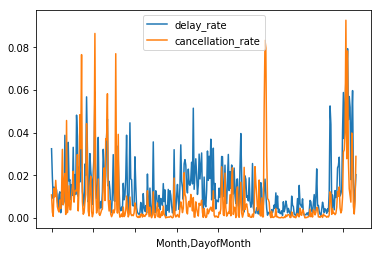

In [28]:
daily_flights.plot()

#### As seen above and the chart here http://www.atl64-flightanalysis.com/
#### there is some visible correlation between winter months and an increase in delays/cancellations due to weather.
#### The most interesting question is if we can use weather forecasts to make estimates on whether a cancellation has increased probability.  Given this is for an insurance case, we will want to create models that penalize false negatives. However, historical forecasts are not so easy to get (certainly not in this dataset). Let's keep exploring:

### Airports with many weather cancellations <a id=cancellationairports></a>

In [33]:
dataset[(dataset.CancellationCode=='B')].groupby('Origin')['Origin'].size().nlargest(5)


Origin
ORD    4896
DFW    3462
IAH    2605
ATL    2498
JFK    2051
Name: Origin, dtype: int64

#### Perhaps Carrier associated delays are more interesting:

### Carrier vs Delay <a id=carrier></a>

In [40]:
def delay_rate(df_sub):
    return df_sub[(df_sub.CarrierDelay>0)]['Year'].count() / float(df_sub['Year'].count())
def cancellation_rate(df_sub):
    return df_sub[(df_sub.CancellationCode=='A')]['Year'].count() / float(df_sub['Year'].count())

def g(x):
    d = {}
    d['delay_rate'] = delay_rate(x)
    d['cancellation_rate'] = cancellation_rate(x)
    d['total'] = x['Year'].count()
    return pd.Series(d, index=['delay_rate','cancellation_rate','total'])
carrier_delay = dataset.groupby(['UniqueCarrier']).apply(g)
carrier_delay.head()

,delay_rate,cancellation_rate,total
UniqueCarrier,,,
9E,0.062,0.017,262208.000
AA,0.120,0.016,604885.000
AQ,0.030,0.005,7800.000
AS,0.082,0.008,151102.000
B6,0.109,0.003,196091.000


####  Delay and cancellation rates vary greatly between carriers.  This is clearly a crucial predictor.

### Distance vs Delay <a id=distance></a>

#### Let's check if distance correlates to non-heav-weather delays.

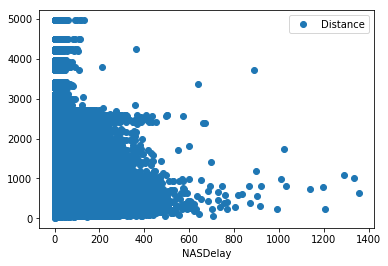

In [46]:
dataset.plot(x='NASDelay', y='Distance', style='o')

In [42]:
dataset['NASDelay'].corr(dataset['Distance'],method='pearson')

0.02915643794069919

In [43]:
dataset['NASDelay'].corr(dataset['Distance'],method='kendall')

0.07274804119640385

In [44]:
dataset['NASDelay'].corr(dataset['Distance'],method='spearman')

0.10277721921593685

#### There might be a linear effect here, but not looking like a strong predictor for now.




### Model for cancellations <a id=model></a>

#### In the file model.R we fit a random forest in R to predict cancellations and use this to check variable importance.  This is merely as an exploration of results and initial benchmarking.

#### Given the highly unbalanced classes, plus the low quality of predictors, the model did not turn out to be ver insightful.  We can definitely attempt to make this work (balance classes out properly, etc.), but seems like a futile exercise if we don't go for the features first.

### Conclusions <a id=conclusions></a>

After this exploratory analysis, we have preliminary results suggesting correlations between weather, distance and carriers with a flight's probability of being cancelled/delayed.

A few pointers for further exploration:

- Interactive Dashboard to further explore the data.

- Cluster the TailNum, Origin and Destination variables.

- Do an outlier analysis.

- Do proper predictive modelling, including feature engineering (main thought here is to enrich the dataset).

- Regarding the business case, it is clear that the potential of introducing weather forecasts is huge and would be of first priority.  We can then proceed to combine this information with airports and carriers to make predictive models that classify flights into cancelled/non-cancelled or delayed/non-delayed categories.
